In [ ]:
#Link del video
# https://youtu.be/fZ1D-JwtIy4

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import random
import math
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
import datetime
plt.style.use('seaborn')
%matplotlib inline

Se importan los datos y crea DataFrame

In [2]:
confirmados_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

confirmados_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,46837,47072,47306,47516,47716,47851,48053,48116,48229,48527
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,41302,42148,42988,43683,44436,45188,46061,46863,47742,48530
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,86730,87502,88252,88825,89416,90014,90579,91121,91638,92102
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,6955,7005,7050,7084,7127,7162,7190,7236,7288,7338
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,15493,15536,15591,15648,15729,15804,15925,16061,16161,16188


In [3]:
cols = confirmados_df.keys()

Se obtienen todas las fechas con casos confirmados

In [4]:
from datetime import date
prim_dia = date(2020, 1, 22)
ult_dia = date(2020, 11, 24)
# ult_dia = date(int(input('Ingrese año:')),int(input('Ingrese mes:')),int(input('Ingrese día:')))
rango = ult_dia - prim_dia
dias = rango.days + 4

In [5]:
#El método DataFrame.loc [] es un método de Pandas que solo toma etiquetas de índice y devuelve una fila o un dataframe(en este caso un df)
confirmados = confirmados_df.loc[:, cols[4]:cols[dias]]
confirmados.head()


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20
0,0,0,0,0,0,0,0,0,0,0,...,43240,43468,43681,43924,44177,44363,44503,44706,44988,45174
1,0,0,0,0,0,0,0,0,0,0,...,27830,28432,29126,29837,30623,31459,32196,32761,33556,34300
2,0,0,0,0,0,0,0,0,0,0,...,67679,68589,69591,70629,71652,72755,73774,74862,75867,77000
3,0,0,0,0,0,0,0,0,0,0,...,5872,5914,5951,6018,6066,6142,6207,6256,6304,6351
4,0,0,0,0,0,0,0,0,0,0,...,13451,13615,13818,13922,14134,14267,14413,14493,14634,14742


In [6]:
fechas = confirmados.keys()


In [7]:
casos_brasil = []
for i in fechas:
    casos_brasil.append(confirmados_df[confirmados_df['Country/Region']=='Brazil'][i].sum())

Se obtiene el incremento diario



In [8]:
def incremento_diario(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d

# casos confirmados
brasil_incremento_diario = incremento_diario(casos_brasil)

In [9]:
dias_desde_1_22 = np.array([i for i in range(len(fechas))]).reshape(-1, 1)
casos_brasil = np.array(casos_brasil).reshape(-1, 1)
brasil_incremento_diario = np.array(brasil_incremento_diario).reshape(-1, 1)

No handles with labels found to put in legend.


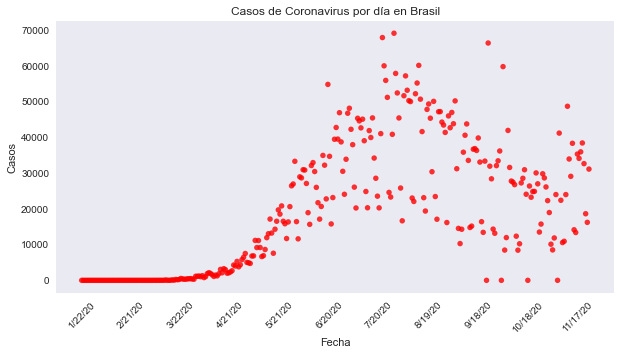

In [10]:
# Crear scatter plot
fig, ax = plt.subplots(figsize=(10,5)) 

for fecha, dia, in zip(fechas, brasil_incremento_diario):
    x, y = fecha, dia
    ax.scatter(x,y , alpha=0.8, edgecolors='none', s=30, color= 'r')
plt.xticks(range(0, len(fechas), 30), rotation=45)
plt.title('Casos de Coronavirus por día en Brasil')
plt.ylabel("Casos")
plt.xlabel("Fecha")
ax.grid(False)
plt.legend(loc=0) 
plt.show()


Se convierten los enteros en "datetime" para mejor visualizacion

---



In [11]:
# modificar ligeramente los datos para que se ajusten mejor al modelo (los modelos de regresión no pueden elegir el patrón)
def muestreo(dias,casos):
    X_train_confirmados, X_test_confirmados, y_train_confirmados, y_test_confirmados = train_test_split(dias, casos, test_size=0.30, shuffle=True, random_state = 42)

    x_train = []
    for i in X_train_confirmados:
        x_train.append(i[0])
    x_train_arr = np.sort(x_train)
    x_train_arr = np.array(x_train_arr).reshape(-1,1)

    x_test = []
    for i in X_test_confirmados:
        x_test.append(i[0])
    x_test_arr = np.sort(x_test)
    x_test_arr = np.array(x_test_arr).reshape(-1,1)

    y_train = []
    for i in x_train_arr:
        y_train.append(int(casos[i][0]))
    y_train_arr = np.array(y_train).reshape(-1,1)
    

    y_test = []
    for i in x_test_arr:
        y_test.append(int(casos[i][0]))
    y_test_arr = np.array(y_test).reshape(-1,1)

    return (x_train_arr,x_test_arr,y_train_arr,y_test_arr)
    
    
x_train,x_test,y_train,y_test = muestreo(dias_desde_1_22,brasil_incremento_diario)

Modelo para predecir el número de casos confirmados. Se usan la máquina de vectores de soporte(vsm), la cresta bayesiana y la regresión lineal en este ejemplo.

In [12]:
# # use this to find the optimal parameters for SVR
# kernel = ['poly', 'sigmoid', 'rbf']
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]

# svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

# svm = SVR()
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=5, verbose=1)
# svm_search.fit(x_train, y_train)


In [13]:
# svm_search.best_params_

In [14]:
# svm_confirmados = svm_search.best_estimator_
svm_confirmados = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmados.fit(x_train, y_train)
svm_pred = svm_confirmados.predict(dias_desde_1_22)
svm_test_pred = svm_confirmados.predict(x_test)
y_svm_pred = svm_confirmados.predict(x_train)

<Figure size 432x288 with 0 Axes>

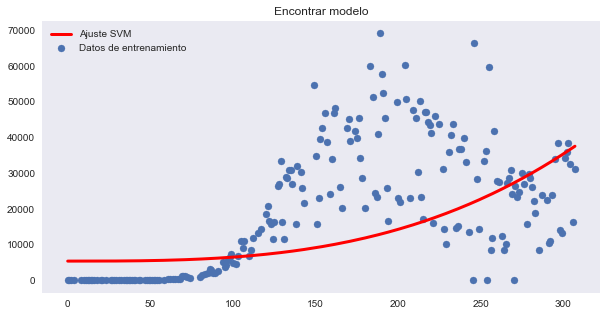

In [15]:
#Grafico datos de entrenamiento para encontrar el modelo SVM
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train,label='train')
plt.plot(x_train,y_svm_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Encontrar modelo')
plt.legend(['Ajuste SVM','Datos de entrenamiento'])
plt.grid()

In [16]:
print("Coeficiente R^2 de entrenamiento SVM: %.2f"
      % r2_score(y_train, y_svm_pred))

Coeficiente R^2 de entrenamiento SVM: 0.03


<Figure size 432x288 with 0 Axes>

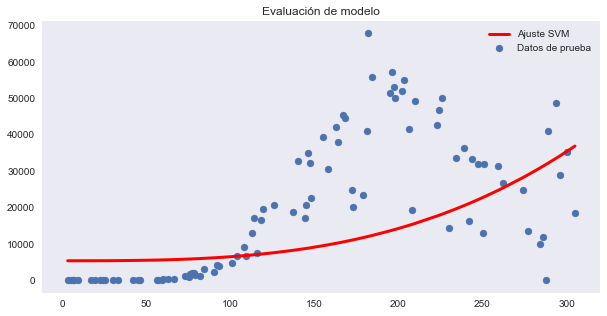

In [17]:
#Grafico datos de prueba para encontrar el modelo SVM
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test,label='test')
plt.plot(x_test,svm_test_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Evaluación de modelo')
plt.legend(['Ajuste SVM','Datos de prueba'])
plt.grid()

In [18]:
print("Coeficiente R^2 de prueba SVM: %.2f"
      % r2_score(y_test, svm_test_pred))

Coeficiente R^2 de prueba SVM: 0.02


In [ ]:
# transformar nuestros datos para la regresión polinomial
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmados = poly.fit_transform(x_train)
poly_X_test_confirmados = poly.fit_transform(x_test)
poly_dias_desde_1_22 = poly.fit_transform(dias_desde_1_22)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmados = bayesian_poly.fit_transform(x_train)
bayesian_poly_X_test_confirmados = bayesian_poly.fit_transform(x_test)
bayesian_poly_dias_desde_1_22 = bayesian_poly.fit_transform(dias_desde_1_22)

In [ ]:
# regresión polinomial
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmados, y_train)
test_linear_pred = linear_model.predict(poly_X_test_confirmados)
linear_pred = linear_model.predict(poly_dias_desde_1_22)
y_poly_pred = linear_model.predict(poly_X_train_confirmados)

In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo Polinomial
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train,label='train')
plt.plot(x_train,y_poly_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Encontrar de modelo')
plt.legend(['Ajuste Polinomial','Datos de entrenamiento'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de entrenamiento polinomial: %.2f"
      % r2_score(y_train, y_poly_pred))

In [ ]:
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test,label='test')
plt.plot(x_test,test_linear_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Evaluación de modelo')
plt.legend(['Ajuste Polinomial','Datos de prueba' ])
plt.grid()

In [ ]:
print("Coeficiente R^2 de prueba polinomial: %.2f"
      % r2_score(y_test, test_linear_pred))

In [ ]:
# regresión polinomial de la cresta bayesiana
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmados, y_train)

In [ ]:
bayesian_search.best_params_

In [ ]:
bayesian_confirmados = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmados.predict(bayesian_poly_X_test_confirmados)
bayesian_pred = bayesian_confirmados.predict(bayesian_poly_dias_desde_1_22)
y_bayesian_pred = bayesian_confirmados.predict(bayesian_poly_X_train_confirmados)


In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo Bayesiano
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train,label='train')
plt.plot(x_train,y_bayesian_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Encontrar el modelo')
plt.legend(['Ajuste Bayesiano','Datos de entrenamiento'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de entrenamiento Bayesiano: %.2f"
      % r2_score(y_train, y_bayesian_pred))

In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo Bayesiano
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test,label='test')
plt.plot(x_test,test_bayesian_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Evaluación de modelo Bayesiano')
plt.legend(['Ajuste Bayesiano','Datos de prueba'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de prueba Bayesiana: %.2f"
      % r2_score(y_test, test_bayesian_pred))

In [ ]:
brasil_lista = []
for i in brasil_incremento_diario:
    brasil_lista.append(i[0])
max_value = np.max(brasil_lista)
index = brasil_lista.index(np.max(brasil_lista))
index = index +4
print(index)

In [ ]:
confirmados = confirmados_df.loc[:, cols[4]:cols[index]]
confirmados.head()

In [ ]:
fechas = confirmados.keys()


In [ ]:
casos_brasil = []
for i in fechas:
    casos_brasil.append(confirmados_df[confirmados_df['Country/Region']=='Brazil'][i].sum())

In [ ]:
def incremento_diario(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d

# casos confirmados
brasil_incremento_diario = incremento_diario(casos_brasil)

In [ ]:
dias_desde_1_22 = np.array([i for i in range(len(fechas))]).reshape(-1, 1)
casos_brasil = np.array(casos_brasil).reshape(-1, 1)
brasil_incremento_diario = np.array(brasil_incremento_diario).reshape(-1, 1)

In [ ]:
# Crear scatter plot
fig, ax = plt.subplots(figsize=(10,5))

for fecha, dia, in zip(fechas, brasil_incremento_diario):
    x, y = fecha, dia
    ax.scatter(x,y , alpha=0.8, edgecolors='none', s=30, color= 'r')
plt.xticks(range(0, len(fechas), 30), rotation=45)
plt.title('Casos de Coronavirus por día en Brasil')
plt.ylabel("Casos")
plt.xlabel("Fecha")
ax.grid(False)
plt.legend(loc=0) 
plt.show()

In [ ]:
# modificar ligeramente los datos para que se ajusten mejor al modelo (los modelos de regresión no pueden elegir el patrón)
def muestreo(dias,casos):
    X_train_confirmados, X_test_confirmados, y_train_confirmados, y_test_confirmados = train_test_split(dias, casos, test_size=0.30, shuffle=True, random_state = 42)

    x_train = []
    for i in X_train_confirmados:
        x_train.append(i[0])
    x_train_arr = np.sort(x_train)
    x_train_arr = np.array(x_train_arr).reshape(-1,1)

    x_test = []
    for i in X_test_confirmados:
        x_test.append(i[0])
    x_test_arr = np.sort(x_test)
    x_test_arr = np.array(x_test_arr).reshape(-1,1)

    y_train = []
    for i in x_train_arr:
        y_train.append(int(casos[i][0]))
    y_train_arr = np.array(y_train).reshape(-1,1)
    

    y_test = []
    for i in x_test_arr:
        y_test.append(int(casos[i][0]))
    y_test_arr = np.array(y_test).reshape(-1,1)

    return (x_train_arr,x_test_arr,y_train_arr,y_test_arr)
    
    
x_train,x_test,y_train,y_test = muestreo(dias_desde_1_22,brasil_incremento_diario)

In [ ]:
# svm_confirmados = svm_search.best_estimator_
svm_confirmados = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=2, C=0.1)
svm_confirmados.fit(x_train, y_train)
svm_pred = svm_confirmados.predict(dias_desde_1_22)
svm_test_pred = svm_confirmados.predict(x_test)
y_svm_pred = svm_confirmados.predict(x_train)

In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo SVM
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train,label='train')
plt.plot(x_train,y_svm_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Encontrar modelo')
plt.legend(['Ajuste SVM','Datos de entrenamiento'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de entrenamiento SVM: %.2f"
      % r2_score(y_train, y_svm_pred))

In [ ]:
#Grafico datos de prueba para encontrar el modelo SVM
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test,label='test')
plt.plot(x_test,svm_test_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Evaluación de modelo')
plt.legend(['Ajuste SVM','Datos de prueba'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de prueba SVM: %.2f"
      % r2_score(y_test, svm_test_pred))

In [ ]:
# transformar nuestros datos para la regresión polinomial
poly = PolynomialFeatures(degree=2)
poly_X_train_confirmados = poly.fit_transform(x_train)
poly_X_test_confirmados = poly.fit_transform(x_test)
poly_dias_desde_1_22 = poly.fit_transform(dias_desde_1_22)

bayesian_poly = PolynomialFeatures(degree=2)
bayesian_poly_X_train_confirmados = bayesian_poly.fit_transform(x_train)
bayesian_poly_X_test_confirmados = bayesian_poly.fit_transform(x_test)
bayesian_poly_dias_desde_1_22 = bayesian_poly.fit_transform(dias_desde_1_22)

In [ ]:
# regresión polinomial
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmados, y_train)
test_linear_pred = linear_model.predict(poly_X_test_confirmados)
linear_pred = linear_model.predict(poly_dias_desde_1_22)
y_poly_pred = linear_model.predict(poly_X_train_confirmados)

In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo Polinomial
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train,label='train')
plt.plot(x_train,y_poly_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Encontrar de modelo')
plt.legend(['Ajuste Polinomial','Datos de entrenamiento'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de entrenamiento polinomial: %.2f"
      % r2_score(y_train, y_poly_pred))

In [ ]:
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test,label='test')
plt.plot(x_test,test_linear_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Evaluación de modelo')
plt.legend(['Ajuste Polinomial','Datos de prueba' ])
plt.grid()

In [ ]:
print("Coeficiente R^2 de prueba polinomial: %.2f"
      % r2_score(y_test, test_linear_pred))

In [ ]:
# regresión polinomial de la cresta bayesiana
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmados, y_train)

In [ ]:
bayesian_search.best_params_

In [ ]:
bayesian_confirmados = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmados.predict(bayesian_poly_X_test_confirmados)
bayesian_pred = bayesian_confirmados.predict(bayesian_poly_dias_desde_1_22)
y_bayesian_pred = bayesian_confirmados.predict(bayesian_poly_X_train_confirmados)


In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo Bayesiano
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train,label='train')
plt.plot(x_train,y_bayesian_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Encontrar el modelo')
plt.legend(['Ajuste Bayesiano','Datos de entrenamiento'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de entrenamiento Bayesiano: %.2f"
      % r2_score(y_train, y_bayesian_pred))

In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo Bayesiano
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test,label='test')
plt.plot(x_test,test_bayesian_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Evaluación de modelo Bayesiano')
plt.legend(['Ajuste Bayesiano','Datos de prueba'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de prueba Bayesiana: %.2f"
      % r2_score(y_test, test_bayesian_pred))

In [ ]:
confirmados = confirmados_df.loc[:, cols[194]:cols[dias]]
confirmados.head()

In [ ]:
fechas = confirmados.keys()

In [ ]:
casos_brasil = []
for i in fechas:
    casos_brasil.append(confirmados_df[confirmados_df['Country/Region']=='Brazil'][i].sum())

In [ ]:
def incremento_diario(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d

# casos confirmados
brasil_incremento_diario = incremento_diario(casos_brasil)

In [ ]:
dias_desde_1_22 = np.array([i for i in range(len(fechas))]).reshape(-1, 1)
casos_brasil = np.array(casos_brasil).reshape(-1, 1)
brasil_incremento_diario = np.array(brasil_incremento_diario).reshape(-1, 1)
brasil_incremento_diario[0] = 69074

In [ ]:
# Crear scatter plot
fig, ax = plt.subplots(figsize=(10,5))

for fecha, dia, in zip(fechas, brasil_incremento_diario):
    x, y = fecha, dia
    ax.scatter(x,y , alpha=0.8, edgecolors='none', s=30, color= 'r')
plt.xticks(range(0, len(fechas), 30), rotation=45)
plt.title('Casos de Coronavirus por día en Brasil')
plt.ylabel("Casos")
plt.xlabel("Fecha")
ax.grid(False)
plt.legend(loc=0)
plt.show()

In [ ]:
# modificar ligeramente los datos para que se ajusten mejor al modelo (los modelos de regresión no pueden elegir el patrón)
def muestreo(dias,casos):
    X_train_confirmados, X_test_confirmados, y_train_confirmados, y_test_confirmados = train_test_split(dias, casos, test_size=0.30, shuffle=True, random_state = 42)

    x_train = []
    for i in X_train_confirmados:
        x_train.append(i[0])
    x_train_arr = np.sort(x_train)
    x_train_arr = np.array(x_train_arr).reshape(-1,1)

    x_test = []
    for i in X_test_confirmados:
        x_test.append(i[0])
    x_test_arr = np.sort(x_test)
    x_test_arr = np.array(x_test_arr).reshape(-1,1)

    y_train = []
    for i in x_train_arr:
        y_train.append(int(casos[i][0]))
    y_train_arr = np.array(y_train).reshape(-1,1)
    

    y_test = []
    for i in x_test_arr:
        y_test.append(int(casos[i][0]))
    y_test_arr = np.array(y_test).reshape(-1,1)

    return (x_train_arr,x_test_arr,y_train_arr,y_test_arr)
    
    
x_train,x_test,y_train,y_test = muestreo(dias_desde_1_22,brasil_incremento_diario)

In [ ]:
# svm_confirmados = svm_search.best_estimator_
svm_confirmados = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmados.fit(x_train, y_train)
svm_pred = svm_confirmados.predict(dias_desde_1_22)
svm_test_pred = svm_confirmados.predict(x_test)
y_svm_pred = svm_confirmados.predict(x_train)

In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo SVM
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train,label='train')
plt.plot(x_train,y_svm_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Encontrar modelo')
plt.legend(['Ajuste SVM','Datos de entrenamiento'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de entrenamiento SVM: %.2f"
      % r2_score(y_train, y_svm_pred))

In [ ]:
#Grafico datos de prueba para encontrar el modelo SVM
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test,label='test')
plt.plot(x_test,svm_test_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Evaluación de modelo')
plt.legend(['Ajuste SVM','Datos de prueba'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de prueba SVM: %.2f"
      % r2_score(y_test, svm_test_pred))

In [ ]:
# transformar nuestros datos para la regresión polinomial
poly = PolynomialFeatures(degree=2)
poly_X_train_confirmados = poly.fit_transform(x_train)
poly_X_test_confirmados = poly.fit_transform(x_test)
poly_dias_desde_1_22 = poly.fit_transform(dias_desde_1_22)

bayesian_poly = PolynomialFeatures(degree=2)
bayesian_poly_X_train_confirmados = bayesian_poly.fit_transform(x_train)
bayesian_poly_X_test_confirmados = bayesian_poly.fit_transform(x_test)
bayesian_poly_dias_desde_1_22 = bayesian_poly.fit_transform(dias_desde_1_22)

In [ ]:
# regresión polinomial
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmados, y_train)
test_linear_pred = linear_model.predict(poly_X_test_confirmados)
linear_pred = linear_model.predict(poly_dias_desde_1_22)
y_poly_pred = linear_model.predict(poly_X_train_confirmados)

In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo Polinomial
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train,label='train')
plt.plot(x_train,y_poly_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Encontrar de modelo')
plt.legend(['Ajuste Polinomial','Datos de entrenamiento'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de entrenamiento polinomial: %.2f"
      % r2_score(y_train, y_poly_pred))

In [ ]:
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test,label='test')
plt.plot(x_test,test_linear_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Evaluación de modelo')
plt.legend(['Ajuste Polinomial','Datos de prueba' ])
plt.grid()

In [ ]:
print("Coeficiente R^2 de prueba polinomial: %.2f"
      % r2_score(y_test, test_linear_pred))

In [ ]:
# regresión polinomial de la cresta bayesiana
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmados, y_train)

In [ ]:
bayesian_search.best_params_

In [ ]:
bayesian_confirmados = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmados.predict(bayesian_poly_X_test_confirmados)
bayesian_pred = bayesian_confirmados.predict(bayesian_poly_dias_desde_1_22)
y_bayesian_pred = bayesian_confirmados.predict(bayesian_poly_X_train_confirmados)


In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo Bayesiano
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train,label='train')
plt.plot(x_train,y_bayesian_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Encontrar el modelo')
plt.legend(['Ajuste Bayesiano','Datos de entrenamiento'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de entrenamiento Bayesiano: %.2f"
      % r2_score(y_train, y_bayesian_pred))

In [ ]:
#Grafico datos de entrenamiento para encontrar el modelo Bayesiano
plt.figure(12)
plt.figure(figsize=(10,5))
plt.scatter(x_test,y_test,label='test')
plt.plot(x_test,test_bayesian_pred, label='ajuste', color='r', linewidth=3.0)
plt.title('Evaluación de modelo Bayesiano')
plt.legend(['Ajuste Bayesiano','Datos de prueba'])
plt.grid()

In [ ]:
print("Coeficiente R^2 de prueba Bayesiana: %.2f"
      % r2_score(y_test, test_bayesian_pred))